<a href="https://colab.research.google.com/github/sskyau/age-gender-cnn/blob/main/age_gender_submit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Age Estimation and Gender Classification

In this assignment, you will train CNN models to estimate a person's age and gender by given a face image. Please read carefully all the instructions before you start to write your code.

**Your tasks**

You need train two CNN models:
- one is defined by you with a few restrictions and be trained from scratch, save it as `age_gender_A.h5`
- the other is to finetune a pretrained model, save it as `age_gender_B.h5`

**Dataset**

Your models will be trained and validated on a folder `train_val/` containing 5,000 labeled face images (size: 128 x 128), originated from the UTKFace dataset. During marking, your code will be tested on unseen test data. 

**Performance metric**

The metrics for measuring the performance on the test set are:
- age estimation: MAE (Mean Absolute Error)
- gender classification: accuracy

**Please use the GPU time wisely.**

Just be aware that there is some limit of free GPU usage (It is said the users can use up to 12 hours in row. But many people found they reached its limit far less than 12 hours.). Therefore, I would give you three suggestions to mimimise the risk of reaching the limit.

1. Make sure you have a stable internet connection.
2. Double check all the hyperparameters are good before you start to train the model.
3. According to my experience, each model should be trained in less than 2 hours. If much longer than that, you'd better consider adjusting the architecture.

## Setting Up: Mount the google drive
Mount your google drive to the notebook. 

Also don't forget to **enable GPU** before your training.


In [ ]:
# Test connection to GPU
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Found GPU at: /device:GPU:0
Mounted at /content/drive


In [ ]:
# Requirements

!pip3 install keras-layer-normalization
!pip3 install keras-utils
!pip3 install tensorflow-addons

  Created wheel for keras-layer-normalization: filename=keras_layer_normalization-0.16.0-py3-none-any.whl size=4668 sha256=aa28803d36370da9a77c5d1b8b5f28e7fe0f088e0c31f66251d0911a3e7f6237
  Stored in directory: /root/.cache/pip/wheels/85/5d/1c/2e619f594f69fbcf8bc20943b27d414871c409be053994813e
Successfully built keras-layer-normalization
  Created wheel for keras-utils: filename=keras_utils-1.0.13-py3-none-any.whl size=2656 sha256=2d160fa77e75309ffda569f32ba04b655ef60ebda3eecc3d882d0560c527c694
  Stored in directory: /root/.cache/pip/wheels/d0/dd/3b/493952a5240d486a83805d65360dedadbadeae71d25e2c877f
Successfully built keras-utils
     |████████████████████████████████| 1.1 MB 14.4 MB/s 


In [ ]:
from keras.models import Model
from keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Lambda
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras.optimizers import Adam 
import tensorflow_addons as tfa
import os
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread
from matplotlib.pyplot import imshow
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
import datetime
import numpy as np
from tensorflow.keras.utils import img_to_array
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from keras.utils.vis_utils import plot_model

## Visualize a few photos
It is always benificial to know your data well before you start. Here display a few (at least 20) images together with its corresponding age and gender from the `train_val/` folder to have a first impression of the dataset. You may also check what the size of the images are.

                                       Name   Age  Gender
0     40_0_3_20170119183403621.jpg.chip.jpg  40.0       0
1     75_0_0_20170117174511134.jpg.chip.jpg  75.0       0
2     18_1_0_20170109213011914.jpg.chip.jpg  18.0       1
3     70_1_3_20170116224931319.jpg.chip.jpg  70.0       1
4     26_1_1_20170116232602440.jpg.chip.jpg  26.0       1
...                                     ...   ...     ...
4995  73_0_0_20170120230235659.jpg.chip.jpg  73.0       0
4996  21_0_1_20170114032109958.jpg.chip.jpg  21.0       0
4997  45_0_1_20170117181136802.jpg.chip.jpg  45.0       0
4998  63_1_0_20170110160643845.jpg.chip.jpg  63.0       1
4999  24_0_2_20170104234829387.jpg.chip.jpg  24.0       0

[5000 rows x 3 columns]


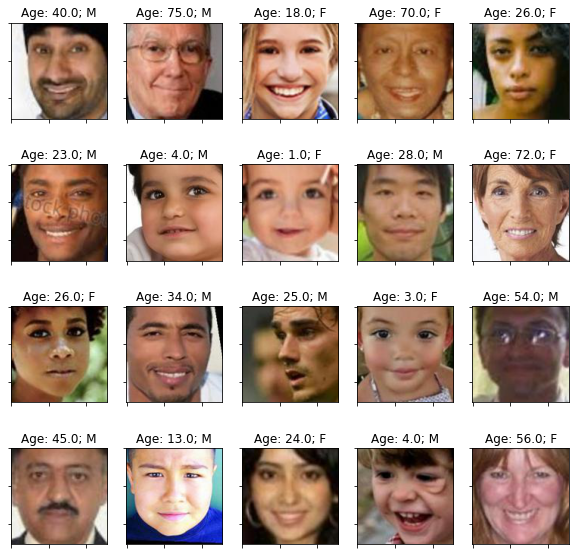

In [ ]:
# Create a mapping table for filename, age and gender
path = '/content/drive/MyDrive/Colab/CM50265-CW1/train_val'
num_image = len(os.listdir(path))

age_list = []
gender_list = []
name_list = []
idx = 0

for filename in os.listdir(path):
  #print(filename)
  indices = [i for i, letter in enumerate(filename) if letter == '_']
  # print('indices', indices)
  age = filename[0:indices[0]]
  gender = filename[indices[0]+1:indices[1]]
  #print('age:' , age)
  #print('gender', gender)
  age_list.append(age)
  gender_list.append(gender)
  name_list.append(filename)

  idx += 1

list_of_tuples = list(zip(name_list, age_list, gender_list))
mapping = pd.DataFrame(list_of_tuples, columns = ['Name', 'Age', 'Gender'])
mapping['Age'] = mapping['Age'].astype(float)
mapping['Gender'] = mapping['Gender'].astype(int)
print(mapping)

# split train and valid 
train_mapping, valid_mapping = np.split(mapping, [int(0.85*len(mapping))])

# Display first 20 images
images = [(n,a,g) for (n,a,g) in zip(mapping.Name[:20], mapping.Age[:20], mapping.Gender[:20])]

# Dict for dislaying gender
gender_dict = {0:"M", 1:"F"}

fig, m_axs = plt.subplots(4, 5, figsize = (10, 10))

# Show the images and label them
for ii, c_ax in enumerate(m_axs.ravel()):
    c_ax.imshow(imread(os.path.join(path, images[ii][0])))
    c_ax.set_title('Age: ' + str(images[ii][1]) + '; ' + gender_dict[images[ii][2]])
    c_ax.set_xticklabels([])
    c_ax.set_yticklabels([])


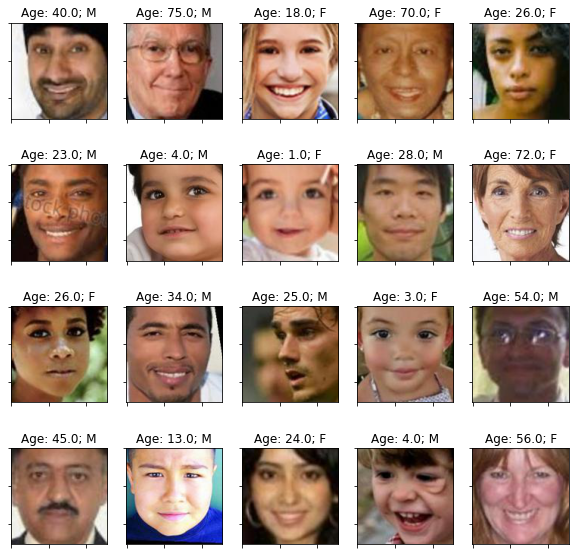

In [ ]:
# Display first 20 images
images = [(n,a,g) for (n,a,g) in zip(mapping.Name[:20], mapping.Age[:20], mapping.Gender[:20])]

# Dict for dislaying gender
gender_dict = {0:"M", 1:"F"}

fig, m_axs = plt.subplots(4, 5, figsize = (10, 10))

# Show the images and label them
for ii, c_ax in enumerate(m_axs.ravel()):
    c_ax.imshow(imread(os.path.join(path, images[ii][0])))
    c_ax.set_title('Age: ' + str(images[ii][1]) + '; ' + gender_dict[images[ii][2]])
    c_ax.set_xticklabels([])
    c_ax.set_yticklabels([])

## Rearrange the dataset
You may do any arrangement for the dataset to suit your later process, such as splitting into training set and validation set, saving the gender labels and age some how, and so on.


In [ ]:
#
# Add your code here
#


## STEP1: Data pre-processing
Now you need do some pre-processing before feeding data into a CNN network. You may consider:

1.	Rescale the pixel values (integers between 0 and 255) to [0,1]. **You must do this rescaling.** Otherwise the testing performance will be affected significantly, as the test images will be rescaling in this way. 
2.	Data augmentation.

**Don't rescale the age to [0,1].** Otherwise the testing performance will be affected significantly, as the original age is used in the testing stage. 

In [ ]:
# Data augmentation and resizing

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   brightness_range=[0.2,1.5],
                                   zoom_range=0.1,
                                   horizontal_flip=True)

valid_datagen = ImageDataGenerator(rescale=1./255)

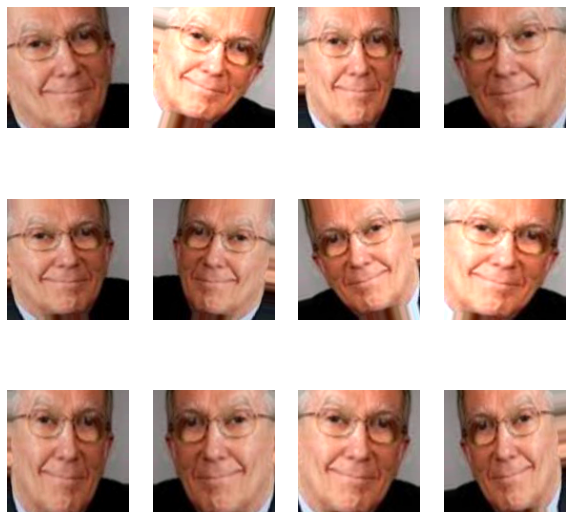

In [ ]:
# Visualise augmented training images
from tensorflow.keras.preprocessing import image

img = imread(os.path.join(path , os.listdir(path)[1]))
x = image.img_to_array(img)
x = x.reshape((1,)+x.shape) #reshape it to (1,150,150,3)
i = 0
plt.figure(figsize=(10,10))
for batch in train_datagen.flow(x,batch_size=1):
  plt.subplot(3,4,i+1)
  plt.axis("off")
  imgplot = plt.imshow(image.array_to_img(batch[0]))
  i += 1
  if i%12 == 0:
    break
plt.show()

## STEP2A: Build your own CNN network
Define your own CNN for classifying the gender and predicting the age. Though there are two tasks, you need **only one CNN model, but with two outputs** - you may search online for solution.

There are a few restrictions about your network as follows.
1.	The input size must be 128 x 128 x 3, which means you **should not resize** the original images. This is because my test code relies on this particular input size. Any other size will cause problem in the testing stage.
2.  Please treat the gender classification as a binary problem, i.e., **the output layer for the gender branch has only 1 unit**, instead of 2 (though it is correct to treat the gender classification as a mutli-class problem where class number is 2, the last layer has 2 units). This is because my test code only works for the 1-unit-last-layer gender branch setting. 
3.	The size of feature maps being fed to the first fully connected layer must be less than 10 x 10, while there is no number limitation about the depth.
4.	You may choose any techniques for preventing overfitting. 

In the end of the cell, use `modelA.summary()` to output the model architecture. You may also use `plot_model()` to visualize its architecture.

In [ ]:
from keras.regularizers import l2
from keras.regularizers import l1
from tensorflow.keras import regularizers

height = 128
width = 128

class MultiOutputModel():

  def create_common(self,inputs):
    x = Conv2D(64, (3, 3), activation='relu')(inputs)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2,2))(x)
    return x

  def build_age_branch(self,inputs):
    x = Conv2D(64, (3, 3), activation='relu')(inputs)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(128, (2, 2), activation='relu')(x)
    x = Conv2D(128, (2, 2), activation='relu')(x)
    x = MaxPooling2D((2,2))(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.05)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.05)(x)
    x = Dense(1, activation='linear', name='age_output')(x) 
    return x

  def build_gender_branch(self,inputs):
    x = Conv2D(64, (3, 3), activation='relu')(inputs)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(128, (2, 2), activation='relu')(x)
    x = Conv2D(128, (2, 2), activation='relu')(x)
    x = MaxPooling2D((2,2))(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(1, activation='sigmoid', name='gender_output')(x)
    return x
  
  def assemble_full_model(self,width,height):
    input_shape = (height,width,3)
    inputs = Input(shape=input_shape)
    common = self.create_common(inputs)
    age_branch = self.build_age_branch(common)
    gender_branch = self.build_gender_branch(common)
    return Model(inputs=inputs,outputs = [age_branch, gender_branch], name="modelA")



## STEP3A: Compile and train your model
Compile and train your model here. 
Save your model by `modelA.save(your_model_folder+"age_gender_A.h5")` after training. 

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Save the model with `save()` instead of `save_weights()`.** This is because I will load the model by 

`modelA = load_model(model_folder+"age_gender_A.h5")`. 


In [ ]:
train_generator = train_datagen.flow_from_dataframe(dataframe=train_mapping, directory=path, x_col='Name', y_col=['Age','Gender'], target_size=(128,128), color_mode='rgb', class_mode='multi_output', batch_size=32)
valid_generator = valid_datagen.flow_from_dataframe(dataframe=valid_mapping, directory=path, x_col='Name', y_col=['Age','Gender'], target_size=(128,128), color_mode='rgb', class_mode='multi_output', batch_size=32)

Found 4250 validated image filenames.
Found 750 validated image filenames.


Model: "modelA"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_99 (Conv2D)             (None, 126, 126, 64  1792        ['input_14[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_100 (Conv2D)            (None, 124, 124, 64  36928       ['conv2d_99[0][0]']              
                                )                                                            

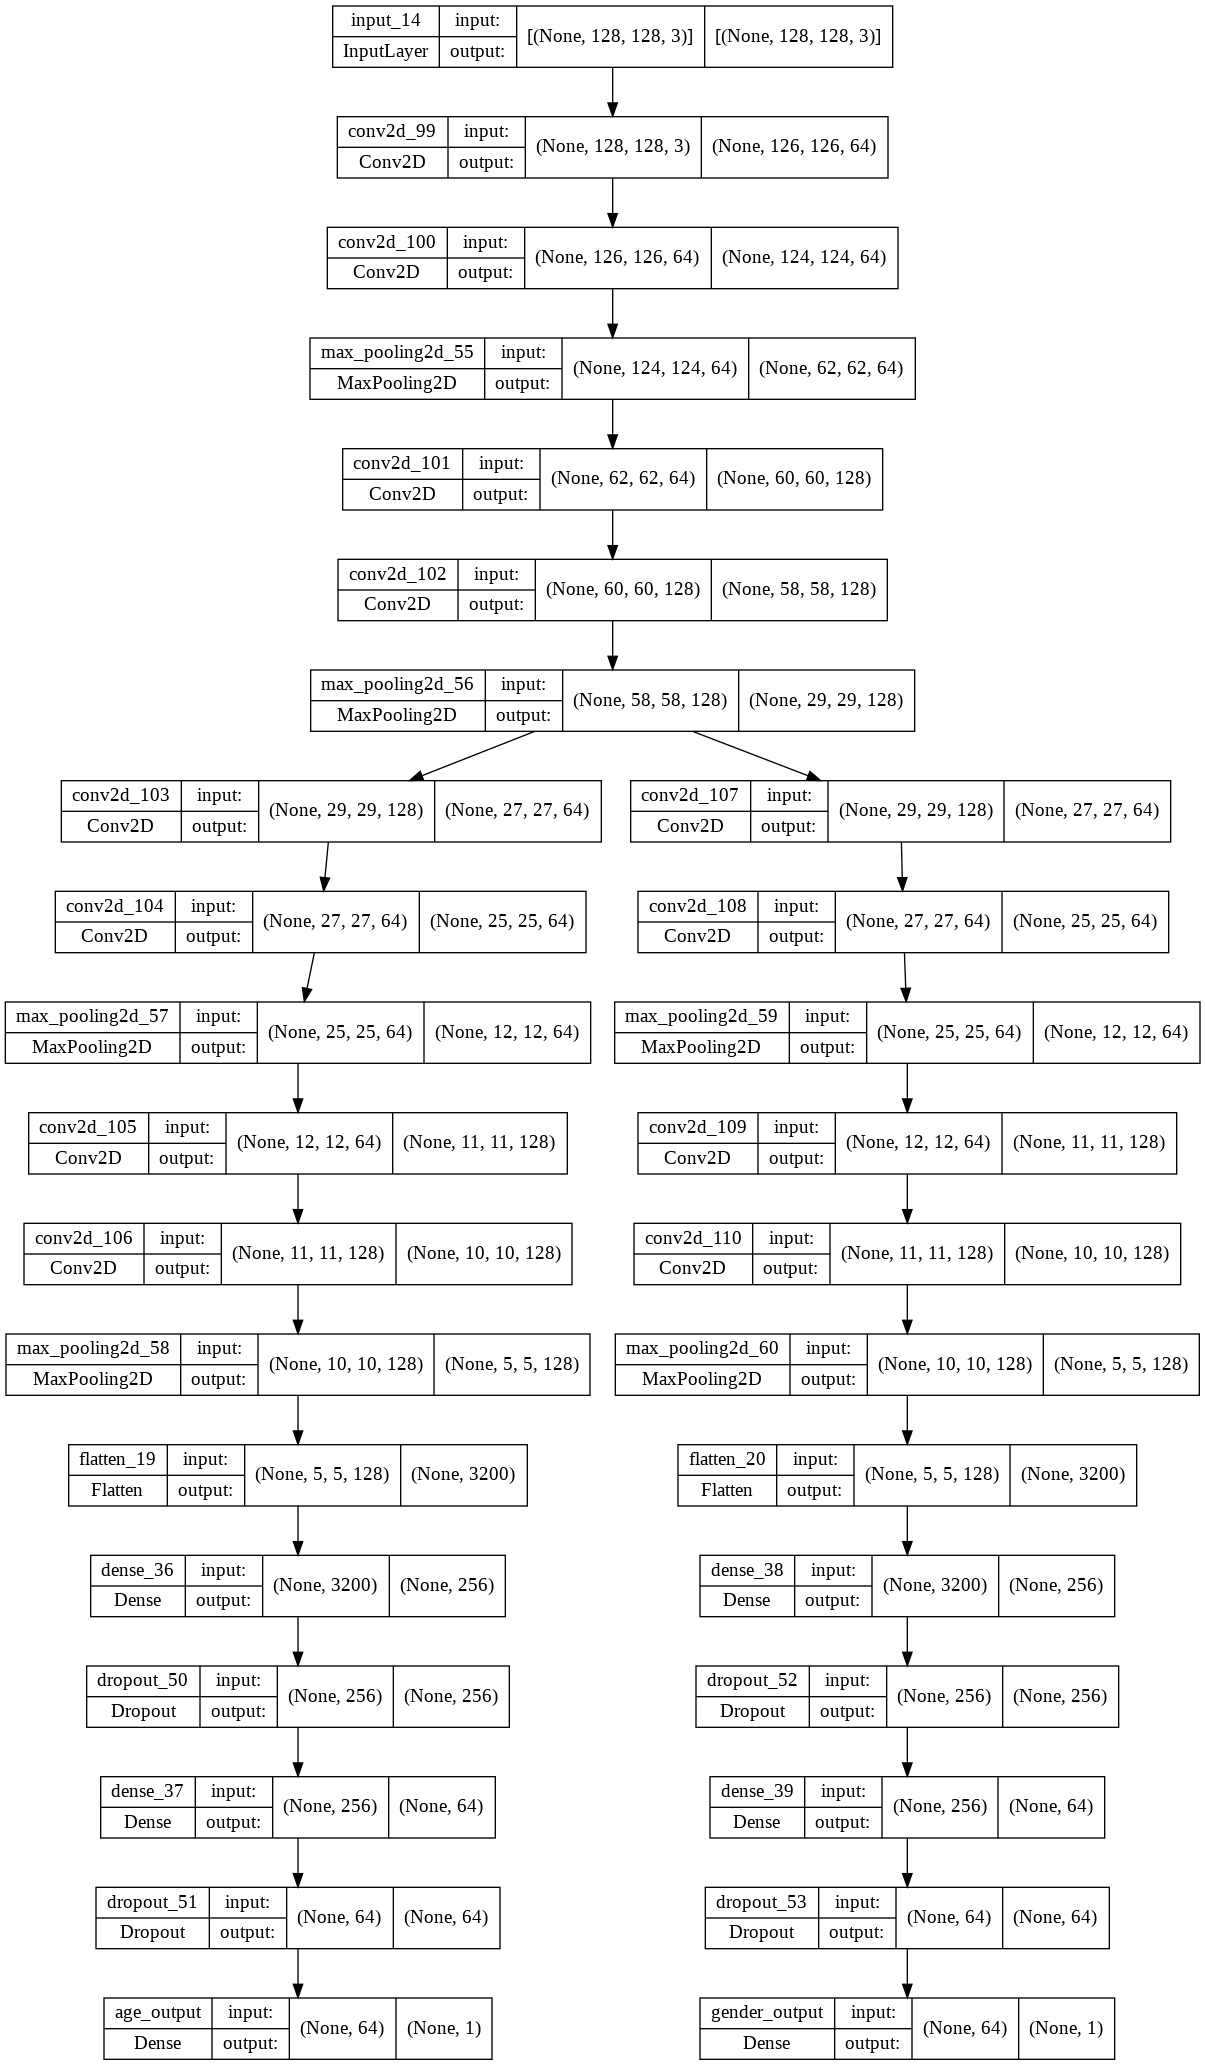

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

def create_and_compile_model():    
  modelA = MultiOutputModel().assemble_full_model(width,height)
  lr_schedule = ExponentialDecay(initial_learning_rate=0.001,decay_steps=(train_generator.n // train_generator.batch_size)*2,decay_rate=0.9)

  modelA.compile(optimizer=Adam(lr_schedule), 
                loss={
                    'age_output': 'mse', 
                    'gender_output': 'binary_crossentropy'},
                loss_weights={
                    'age_output': 1, 
                    'gender_output': 100},
                metrics={
                    'age_output': 'mae', 
                    'gender_output': 'accuracy'})
  return modelA

modelA = create_and_compile_model()
modelA.summary()

from keras.utils.vis_utils import plot_model
plot_model(modelA, show_shapes=True)

In [ ]:
epoch = 100
modelA_train_steps_per_epoch = train_generator.n // train_generator.batch_size
modelA_val_steps_per_epoch = valid_generator.n // valid_generator.batch_size

save_dir = '/content/drive/MyDrive/Colab/CM50265-CW1/models/'
cp_path = save_dir+'modelA/{epoch:02d}-{val_loss:.2f}.h5'

cp_callback = ModelCheckpoint(
    filepath=cp_path,
    monitor='val_loss',
    mode='min', 
    save_best_only=True)

modelA_history = modelA.fit(
    x = train_generator,
    validation_data=valid_generator,
    epochs=epoch,
    steps_per_epoch = modelA_train_steps_per_epoch,
    validation_steps = modelA_val_steps_per_epoch,
    callbacks=[cp_callback]
)

#content_dir = "/content/drive/MyDrive/Colab/CM50265-CW1/"
#modelA.save(content_dir+"age_gender_A2.h5")

Epoch 1/100
132/132 [==============================] - 31s 227ms/step - loss: 635.3430 - age_output_loss: 566.0067 - gender_output_loss: 0.6934 - age_output_mae: 18.3242 - gender_output_accuracy: 0.5126 - val_loss: 474.5273 - val_age_output_loss: 405.2539 - val_gender_output_loss: 0.6927 - val_age_output_mae: 14.7889 - val_gender_output_accuracy: 0.5149
Epoch 2/100
132/132 [==============================] - 30s 227ms/step - loss: 483.9718 - age_output_loss: 414.6871 - gender_output_loss: 0.6928 - age_output_mae: 15.6765 - gender_output_accuracy: 0.5175 - val_loss: 451.0429 - val_age_output_loss: 381.7478 - val_gender_output_loss: 0.6930 - val_age_output_mae: 15.2063 - val_gender_output_accuracy: 0.5109
Epoch 3/100
132/132 [==============================] - 30s 226ms/step - loss: 476.5533 - age_output_loss: 407.2891 - gender_output_loss: 0.6926 - age_output_mae: 15.5541 - gender_output_accuracy: 0.5178 - val_loss: 449.0076 - val_age_output_loss: 379.7551 - val_gender_output_loss: 0.6925

## STEP4A: Draw the learning curves
Draw four figures as follows
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set


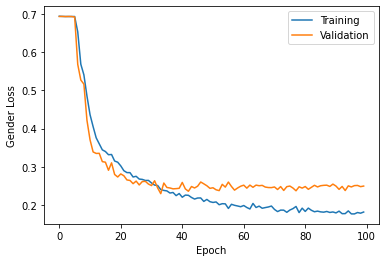

In [ ]:
# 1. The loss of the gender classification over the training and validation set
  
plt.plot(modelA_history.history['gender_output_loss'], label='Training')
plt.plot(modelA_history.history['val_gender_output_loss'], label='Validation')


plt.legend()
#plt.title("Training and Validation Loss of Gender")
plt.xlabel('Epoch')
plt.ylabel('Gender Loss')
plt.show()

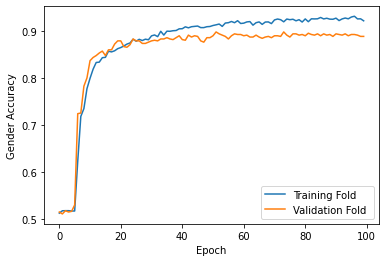

In [ ]:
# 2. The accuracy of the gender classification over the training and validation set
  
plt.plot(modelA_history.history['gender_output_accuracy'], label='Training Fold ')
plt.plot(modelA_history.history['val_gender_output_accuracy'], label='Validation Fold ')
plt.legend()
#plt.title("Training and Validation Accuracy of Gender")
plt.xlabel('Epoch')
plt.ylabel('Gender Accuracy')
plt.show()

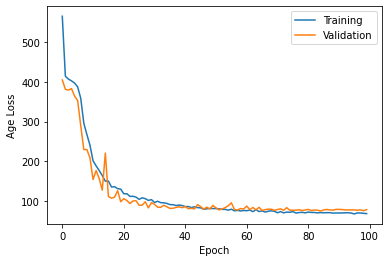

In [ ]:
# 3. The loss of the age estimation over the training and validation set

plt.plot(modelA_history.history['age_output_loss'], label='Training' )
plt.plot(modelA_history.history['val_age_output_loss'], label='Validation' )
plt.legend()
#plt.title("Training and Validation Loss of Age")
plt.xlabel('Epoch')
plt.ylabel('Age Loss')
plt.show()

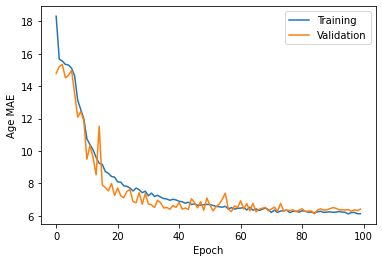

In [ ]:
# 4.  The MAE of the age estimation over the training and validation set
plt.plot(modelA_history.history['age_output_mae'], label='Training')
plt.plot(modelA_history.history['val_age_output_mae'], label='Validation')
plt.legend()
#plt.title("Training and Validation MAE of Age")
plt.xlabel('Epoch')
plt.ylabel('Age MAE')
plt.show()

## STEP2B: Build a CNN network based on a pre-trained model 
Choose one existing CNN architecture pre-trained on ImageNet, and fine-tune on this dataset.

The same as required in Model A, **don’t resize the input image size**. **The output layer for the gender branch is set to have only 1 unit**. 

In the end of the cell, use `modelB.summary()` to output the model architecture. You may also use `plot_model()` to visualize its architecture.


In [ ]:
# Re-define augmnetation

def add_color_distortion(img):
    contrast_range=[0.5, 2.5]

    contrast = np.random.uniform(contrast_range[0], contrast_range[1])
    
    img = tf.image.adjust_contrast(img, contrast)
    img = tf.clip_by_value(img, 0, 255)
    return img

train_datagen = ImageDataGenerator(
                             rescale=1./255, 
                             rotation_range = 45, 
                             horizontal_flip = True,
                             preprocessing_function=add_color_distortion
                             )

valid_datagen = ImageDataGenerator(rescale=1./255)

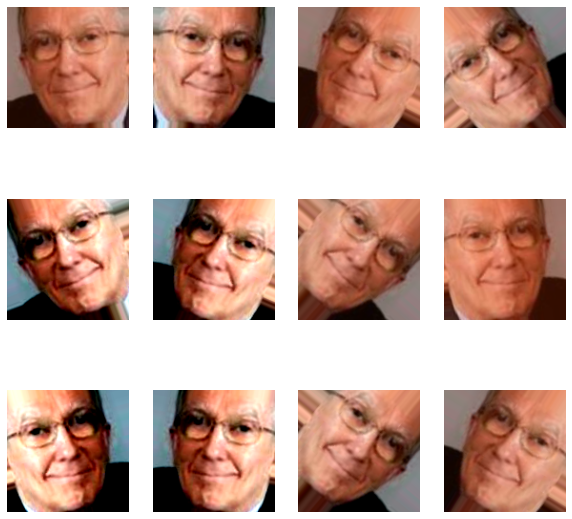

In [ ]:
# Visualise augmented training images

img = imread(os.path.join(path , os.listdir(path)[1]))
x = image.img_to_array(img)
x = x.reshape((1,)+x.shape) 
i = 0
plt.figure(figsize=(10,10))
for batch in train_datagen.flow(x,batch_size=1):
  plt.subplot(3,4,i+1)
  plt.axis("off")
  imgplot = plt.imshow(image.array_to_img(batch[0]))
  i += 1
  if i%12 == 0:
    break
plt.show()

51888128/51877672 [==============================] - 0s 0us/step
Model: "modelB"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 densenet169 (Functional)       (None, 4, 4, 1664)   12642880    ['input_1[0][0]']                
                                                                                                  
 flatten (Flatten)              (None, 26624)        0           ['densenet169[0][0]']            
                                                                                                  
 batch_normalization (BatchN

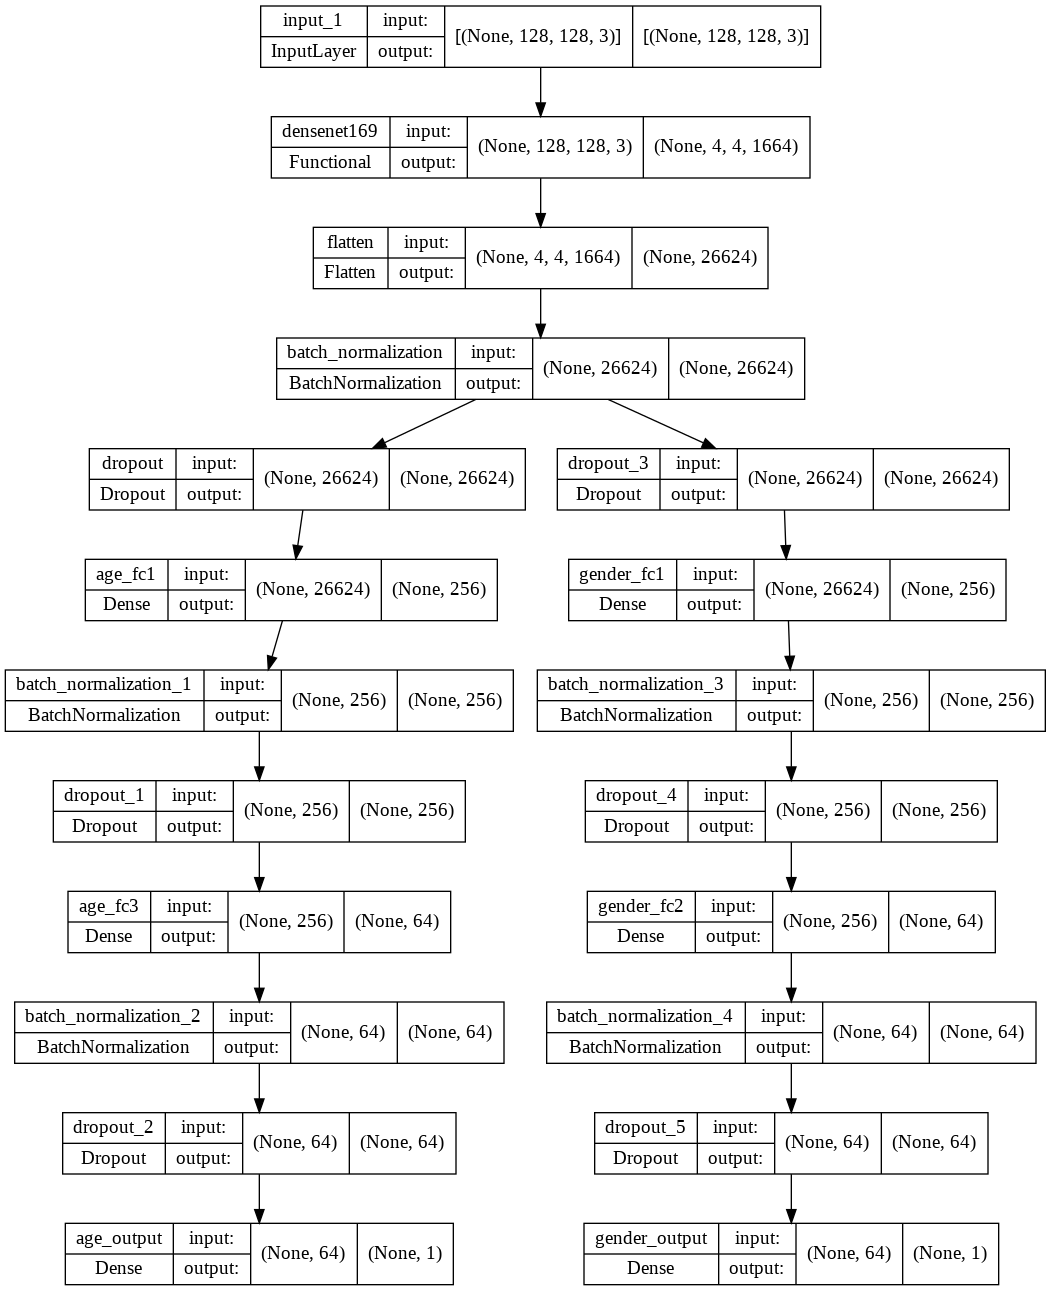

In [ ]:
from tensorflow.keras.applications import DenseNet169 as DN

from keras.backend import batch_normalization
import sys
from matplotlib import pyplot
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2

height = 128
width = 128
input_shape = (height, width, 3)

# Utility function for freezing and unfreezing layers
def freeze_layers(conv_base, end_layer, start_layer=0, freeze=True):
  for layer in conv_base.layers[start_layer:end_layer+1]:
    if freeze:
      layer.trainable = False
    else:
      layer.trainable = True
  return conv_base

def build_age_branch(x):

  x = Dropout(0.5)(x)
  x = Dense(256, activation='relu', name='age_fc1', kernel_initializer='he_normal')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.5)(x)
  x = Dense(64, activation='relu', name='age_fc3', kernel_initializer='he_normal')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.5)(x)
  x = Dense(1, activation='linear', name='age_output')(x)

  
  return x

def build_gender_branch(x):

  x = Dropout(0.8)(x)
  x = Dense(256, activation='relu', name='gender_fc1', kernel_initializer='he_normal')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.8)(x)
  x = Dense(64, activation='relu', name='gender_fc2', kernel_initializer='he_normal')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.5)(x)
  x = Dense(1, activation='sigmoid', name='gender_output')(x)


  return x


def create_base_model(input_shape=(128, 128, 3)):
    
    inputs = Input(shape=input_shape)
    
    # Load a pretrained model without the original fully connected layers
    conv_base = DN(weights = 'imagenet', include_top = False, input_shape=input_shape)

    # Freeze all layers
    conv_base.trainable = False
    pre_trained = conv_base(inputs, training = False)
    pre_trained = Flatten()(pre_trained)
    pre_trained = BatchNormalization()(pre_trained)

    age_branch = build_age_branch(pre_trained)
    gender_branch = build_gender_branch(pre_trained)

    return tf.keras.Model(inputs=inputs, outputs=[age_branch, gender_branch], name='modelB')


modelB = create_base_model()
modelB.summary()
plot_model(modelB, show_shapes=True)

In [ ]:
batch_size = 128
model_history = [] 
fe_epoch = 100


es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                               patience=5,
                                               mode='min', 
                                               verbose=True)


train_gen = train_datagen.flow_from_dataframe(dataframe=train_mapping, 
                                        directory=path, 
                                        x_col="Name", 
                                        y_col=["Age", "Gender"], 
                                        class_mode='multi_output', 
                                        target_size=(128,128),
                                        batch_size = batch_size)

valid_gen = valid_datagen.flow_from_dataframe(dataframe=valid_mapping, 
                                        directory=path, 
                                        x_col="Name", 
                                        y_col=["Age", "Gender"], 
                                        class_mode='multi_output', 
                                      target_size=(128,128),
                                      batch_size = batch_size)


Found 4250 validated image filenames.
Found 750 validated image filenames.


In [ ]:
# Step 1: Feature extraction

modelB.compile(
              optimizer=Adam(), 
              loss={
                  'age_output': 'mse', 

                  'gender_output': 'binary_crossentropy'},
              loss_weights={
                  'age_output': 0.5, 
                  'gender_output': 300},
              metrics={
                  'age_output': 'mae', 
                  'gender_output': 'accuracy'})


model_history.append(modelB.fit(
  x=train_gen,
  validation_data=valid_gen,
  epochs=fe_epoch,
  callbacks=[es_callback]
))

Epoch 1/100
34/34 [==============================] - 81s 960ms/step - loss: 917.4728 - age_output_loss: 1397.6387 - gender_output_loss: 0.7288 - age_output_mae: 33.1460 - gender_output_accuracy: 0.6711 - val_loss: 1514.1141 - val_age_output_loss: 2599.0537 - val_gender_output_loss: 0.7153 - val_age_output_mae: 47.5837 - val_gender_output_accuracy: 0.8200
Epoch 2/100
34/34 [==============================] - 31s 901ms/step - loss: 829.7435 - age_output_loss: 1312.6512 - gender_output_loss: 0.5781 - age_output_mae: 32.6660 - gender_output_accuracy: 0.7419 - val_loss: 1029.6295 - val_age_output_loss: 1747.5505 - val_gender_output_loss: 0.5195 - val_age_output_mae: 39.1539 - val_gender_output_accuracy: 0.8360
Epoch 3/100
34/34 [==============================] - 30s 882ms/step - loss: 789.9556 - age_output_loss: 1245.9021 - gender_output_loss: 0.5567 - age_output_mae: 32.1558 - gender_output_accuracy: 0.7466 - val_loss: 912.7519 - val_age_output_loss: 1575.6295 - val_gender_output_loss: 0.41

In [ ]:
# Step 2: Fine-tuning

# Load the best model trained in feature selection stage

#save_dir = '/content/drive/MyDrive/Colab/CM50265-CW1/models/'
#modelB = tf.keras.models.load_model(save_dir+"modelB_60.h5")

In [ ]:
# unfreeze layers last three dense blocks within the pre-trained model
freeze_layers(modelB.layers[1], end_layer=52, start_layer=0, freeze=True)

In [ ]:
# print out the layers of modelB to check the correct layers are unfrozen
layer_id = 0
for layer in modelB.layers[1].layers:
  print(layer_id,' ' , layer.name, ": ", layer.trainable)
  layer_id+=1
  #layer.trainable = True

0   input_30 :  False
1   zero_padding2d_28 :  False
2   conv1/conv :  False
3   conv1/bn :  False
4   conv1/relu :  False
5   zero_padding2d_29 :  False
6   pool1 :  False
7   conv2_block1_0_bn :  False
8   conv2_block1_0_relu :  False
9   conv2_block1_1_conv :  False
10   conv2_block1_1_bn :  False
11   conv2_block1_1_relu :  False
12   conv2_block1_2_conv :  False
13   conv2_block1_concat :  False
14   conv2_block2_0_bn :  False
15   conv2_block2_0_relu :  False
16   conv2_block2_1_conv :  False
17   conv2_block2_1_bn :  False
18   conv2_block2_1_relu :  False
19   conv2_block2_2_conv :  False
20   conv2_block2_concat :  False
21   conv2_block3_0_bn :  False
22   conv2_block3_0_relu :  False
23   conv2_block3_1_conv :  False
24   conv2_block3_1_bn :  False
25   conv2_block3_1_relu :  False
26   conv2_block3_2_conv :  False
27   conv2_block3_concat :  False
28   conv2_block4_0_bn :  False
29   conv2_block4_0_relu :  False
30   conv2_block4_1_conv :  False
31   conv2_block4_1_bn :  Fa

In [ ]:
ft_epoch = 150
fe_history = []
ft_history = []

# for saving the best model trained so far during training
'''
cp_path = save_dir+'FT/final_1/{epoch:02d}-{val_loss:.2f}.h5'
#print(cp_path)

cp_callback = ModelCheckpoint(
    filepath=cp_path,
    monitor='val_loss',
    mode='min', 
    save_best_only=True)
'''

# compile the model
modelB.compile(optimizer=Adam(1e-5), 
              loss={
                  'age_output': 'mse', 
                  'gender_output': 'binary_crossentropy'},
              loss_weights={
                  'age_output': 4, 
                  'gender_output': 250},
              metrics={
                  'age_output': 'mae', 
                  'gender_output': 'accuracy'})

# train the model
ft_history = modelB.fit(
    x=train_gen,
    validation_data=valid_gen,
    epochs=ft_epoch,
    #callbacks=[cp_callback]
    )

Epoch 1/150
34/34 [==============================] - 60s 999ms/step - loss: 563.1578 - age_output_loss: 119.5624 - gender_output_loss: 0.3396 - age_output_mae: 8.2286 - gender_output_accuracy: 0.8513 - val_loss: 478.4035 - val_age_output_loss: 100.5103 - val_gender_output_loss: 0.3054 - val_age_output_mae: 7.5399 - val_gender_output_accuracy: 0.8693
Epoch 2/150
34/34 [==============================] - 30s 890ms/step - loss: 539.6212 - age_output_loss: 114.9713 - gender_output_loss: 0.3189 - age_output_mae: 8.1213 - gender_output_accuracy: 0.8607 - val_loss: 456.6555 - val_age_output_loss: 95.5911 - val_gender_output_loss: 0.2972 - val_age_output_mae: 7.2710 - val_gender_output_accuracy: 0.8800
Epoch 3/150
34/34 [==============================] - 31s 895ms/step - loss: 512.1116 - age_output_loss: 108.7644 - gender_output_loss: 0.3082 - age_output_mae: 7.8456 - gender_output_accuracy: 0.8633 - val_loss: 444.1284 - val_age_output_loss: 91.4273 - val_gender_output_loss: 0.3137 - val_age_ou

## STEP3B: Compile and train your model
Compile and train your model here. 
Save your model to `age_gender_B.h5` after training. 

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Also, save the model with `save()` instead of `save_weights()`.** 


## STEP4B: Draw the learning curve
Draw four figures as follows
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set

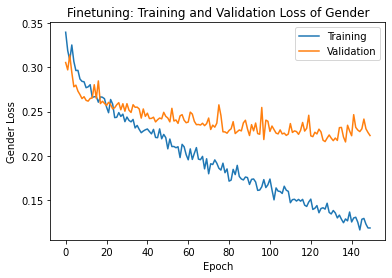

In [ ]:
# 1. The loss of the gender classification over the training and validation set

plt.plot(ft_history.history['gender_output_loss'], label='Training')
plt.plot(ft_history.history['val_gender_output_loss'], label='Validation')
plt.legend()
plt.title("Finetuning: Training and Validation Loss of Gender")
plt.xlabel('Epoch')
plt.ylabel('Gender Loss')
plt.show()

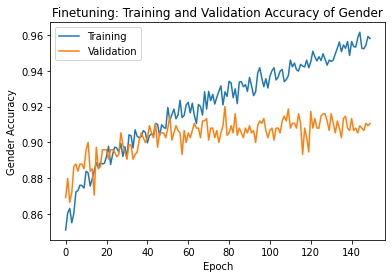

In [ ]:
# 2. The accuracy of the gender classification over the training and validation set

plt.plot(ft_history.history['gender_output_accuracy'], label='Training')
plt.plot(ft_history.history['val_gender_output_accuracy'], label='Validation')
plt.legend()
plt.title("Finetuning: Training and Validation Accuracy of Gender")
plt.xlabel('Epoch')
plt.ylabel('Gender Accuracy')
plt.show()

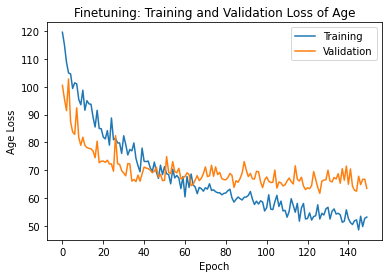

In [ ]:
# 3. The loss of the age estimation over the training and validation set

plt.plot(ft_history.history['age_output_loss'], label='Training')
plt.plot(ft_history.history['val_age_output_loss'], label='Validation')
plt.legend()
plt.title("Finetuning: Training and Validation Loss of Age")
plt.xlabel('Epoch')
plt.ylabel('Age Loss')
plt.show()

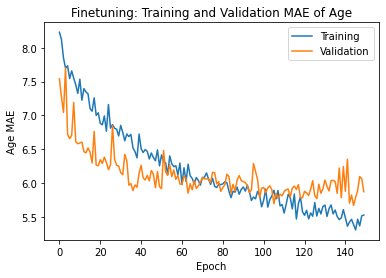

In [ ]:
# 4.  The MAE of the age estimation over the training and validation set

plt.plot(ft_history.history['age_output_mae'], label='Training')
plt.plot(ft_history.history['val_age_output_mae'], label='Validation')
plt.legend()
plt.title("Finetuning: Training and Validation MAE of Age")
plt.xlabel('Epoch')
plt.ylabel('Age MAE')
plt.show()

## STEP5: Evaluate the model on the test set
I will add my test code here to test the two models you trained. The test set will not be available before your submission. 

The metrics for measuring the performance on the test set are:
- age estimation: MAE (Mean Absolute Error)
- gender classification: accuracy


In [ ]:
#
# Don't add code in this cell when submitting this file
#